In [1]:
try:
    import tinygp
except ImportError:
    %pip install -q tinygp

try:
    import flax
except ImportError:
    %pip install -q flax

try:
    import optax
except ImportError:
    %pip install -q optax

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Liberation Sans


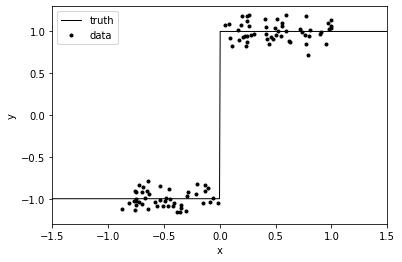

In [2]:
import numpy as np
import matplotlib.pyplot as plt

random = np.random.default_rng(567)

noise = 0.1

x = np.sort(random.uniform(-1, 1, 100))
y = 2 * (x > 0) - 1 + random.normal(0.0, noise, len(x))
t = np.linspace(-1.5, 1.5, 500)

plt.plot(t, 2 * (t > 0) - 1, "k", lw=1, label="truth")
plt.plot(x, y, ".k", label="data")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.3, 1.3)
plt.xlabel("x")
plt.ylabel("y")
_ = plt.legend()

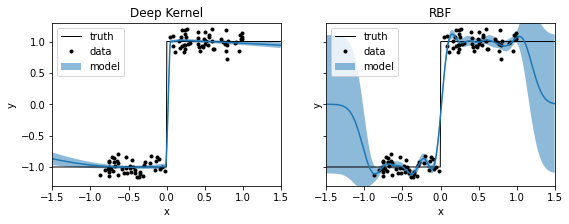

In [10]:
import jax
import optax
import jax.numpy as jnp
import flax.linen as nn
from flax.linen.initializers import zeros
from tinygp import kernels, transforms, GaussianProcess

class RBF_Kernel_GPLoss(nn.Module):
    @nn.compact
    def __call__(self, x, y, t):
        # Set up a typical Squared Exponential kernel
        log_sigma = self.param("log_sigma", zeros, ())
        log_rho = self.param("log_rho", zeros, ())
        log_jitter = self.param("log_jitter", zeros, ())
        kernel = jnp.exp(2 * log_sigma) * kernels.ExpSquared(
            jnp.exp(log_rho)
        )

        # Evaluate and return the GP negative log likelihood as usual
        gp = GaussianProcess(
            kernel, x[:, None], diag=noise**2 + jnp.exp(2 * log_jitter)
        )
        log_prob, gp_cond = gp.condition(y, t[:, None])
        return -log_prob, (gp_cond.loc, gp_cond.variance)

# Define a small neural network used to non-linearly transform the input data in our model
class Transformer(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=15)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)
        return x


class Deep_Kernel_GPLoss(nn.Module):
    @nn.compact
    def __call__(self, x, y, t):
        # Set up a typical Matern-3/2 kernel
        log_sigma = self.param("log_sigma", zeros, ())
        log_rho = self.param("log_rho", zeros, ())
        log_jitter = self.param("log_jitter", zeros, ())
        base_kernel = jnp.exp(2 * log_sigma) * kernels.Matern32(
            jnp.exp(log_rho)
        )

        # Define a custom transform to pass the input coordinates through our `Transformer`
        # network from above
        transform = Transformer()
        kernel = transforms.Transform(transform, base_kernel)

        # Evaluate and return the GP negative log likelihood as usual
        gp = GaussianProcess(
            kernel, x[:, None], diag=noise**2 + jnp.exp(2 * log_jitter)
        )
        log_prob, gp_cond = gp.condition(y, t[:, None])
        return -log_prob, (gp_cond.loc, gp_cond.variance)


def rbf_kernel_loss(params):
    return rbf_kernel_model.apply(params, x, y, t)[0]

def deep_kernel_loss(params):
    return deep_kernel_model.apply(params, x, y, t)[0]


rbf_kernel_model = RBF_Kernel_GPLoss()
deep_kernel_model = Deep_Kernel_GPLoss()

rbf_kernel_params = rbf_kernel_model.init(jax.random.PRNGKey(1234), x, y, t)
deep_kernel_params = deep_kernel_model.init(jax.random.PRNGKey(1234), x, y, t)

rbf_kernel_tx = optax.sgd(learning_rate=1e-4)
rbf_kernel_opt_state = rbf_kernel_tx.init(rbf_kernel_params)
rbf_kernel_loss_grad_fn = jax.jit(jax.value_and_grad(rbf_kernel_loss))
for i in range(1000):
    loss_val, grads = rbf_kernel_loss_grad_fn(rbf_kernel_params)
    updates, opt_state = rbf_kernel_tx.update(grads, opt_state)
    rbf_kernel_params = optax.apply_updates(rbf_kernel_params, updates)

deep_kernel_tx = optax.sgd(learning_rate=1e-4)
deep_kernel_opt_state = deep_kernel_tx.init(deep_kernel_params)
deep_kernel_loss_grad_fn = jax.jit(jax.value_and_grad(deep_kernel_loss))
for i in range(1000):
    loss_val, grads = deep_kernel_loss_grad_fn(deep_kernel_params)
    updates, opt_state = deep_kernel_tx.update(grads, opt_state)
    deep_kernel_params = optax.apply_updates(deep_kernel_params, updates)

# Plot the results and compare to the true model
fig, ax = plt.subplots(ncols = 2, sharey = True, figsize=(9, 3))
for it, (model_name, model, params) in enumerate(zip(["Deep Kernel", "RBF"], [deep_kernel_model, rbf_kernel_model], [deep_kernel_params, rbf_kernel_params])):
    mu, var = model.apply(params, x, y, t)[1]
    ax[it].plot(t, 2 * (t > 0) - 1, "k", lw=1, label="truth")
    ax[it].plot(x, y, ".k", label="data")
    ax[it].plot(t, mu)
    ax[it].fill_between(
        t, mu + np.sqrt(var), mu - np.sqrt(var), alpha=0.5, label="model"
    )
    ax[it].set_xlim(-1.5, 1.5)
    ax[it].set_ylim(-1.3, 1.3)
    ax[it].set_xlabel("x")
    ax[it].set_ylabel("y")
    ax[it].set_title(model_name)
    _ = ax[it].legend()

In [11]:
transform = Transformer()
z = transform(x)
plt.figure()
plt.plot(x, z, label = "Transformed Input")
plt.scatter(x, y, color = 'k', alpha = 0.7, s = 25, label = "Data")
plt.legend()

CallCompactUnboundModuleError: Can't call compact methods on unbound modules (https://flax.readthedocs.io/en/latest/flax.errors.html#flax.errors.CallCompactUnboundModuleError)